In [1]:
import os
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#makes the view of the page a bit wider. Nice!
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:70%!important;width:auto!important;}</style>"))

def lookupLocation(regionCode):
    //Todo. implement a lookup table for region code -> region name 
devon = "5E61297"
isleOfWight = "5E61521"
cornwall = "5E61294"

In [ ]:
def extractRegionCodeFromUrl(url):
    regionFullStringPattern = "REGION%......."
    regionCode = re.search(regionFullStringPattern, url).group()[-7:]
    return regionCode

In [3]:
def getResponseObjectFromClient(noOfBed, regionCode, pageNo):
    #start from page 0 
    index = str(pageNo * 24)
    noOfBed = str(noOfBed)
    regionCode = str(regionCode)
    
    url = 'https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=REGION%'+regionCode+'&maxBedrooms='+noOfBed+'&minBedrooms='+noOfBed+'&index='+index+'&propertyTypes=&includeSSTC=false&mustHave=&dontShow=&furnishTypes=&keywords='
    #returns 200 if successfull
    response = requests.get(url)
    return response

In [10]:
def gatherData(noOfBed, regionCode):
    pageNo = 0
    successCode = 200
    responseCode = successCode
    fileRoot = os.getcwd()
    cwd = os.getcwd()
    
    while responseCode == successCode:
        bedNoPath = "/" + str(noOfBed)
        regionPath = "/" + regionCode
        fileName = regionCode + "-" + str(noOfBed) + "-" + str(pageNo) + "-response.txt"
        
        dirPath = fileRoot + regionPath + bedNoPath + "/"
        fullPath = dirPath + fileName
        
        isFile = os.path.isfile(fullPath) 
        isRegionPath = os.path.exists(fileRoot+regionPath)
        isBedNoPath = os.path.exists(fileRoot+ regionPath + bedNoPath)
        
        if(isRegionPath == False):
            os.mkdir(fileRoot+regionPath)
        if(isBedNoPath == False):
            os.chdir(fileRoot+regionPath)
            os.mkdir(os.getcwd()+ bedNoPath)
            os.chdir(fileRoot)
        if(isFile == False):
            response = getResponseObjectFromClient(noOfBed, regionCode, pageNo)
            responseCode = int(response.status_code)
            if(responseCode == successCode):
                responseText = BeautifulSoup(response.text, "html.parser")
                with open(fullPath, 'w') as clientRes:
                    clientRes.write(str(responseText))
        pageNo+=1 

In [44]:
#The string we're interested in from the raw response -> displayPrice : ''">£925,000
#get our cached data

#TODO MAKE THIS REACH IN TO THE CORRECT FOLDER AND PRINT OUT A CONTINUOUS CSV OF ALL THE PRICES 
def extractPricesToCSV(noOfBed, regionCode):
    csvFileName = regionCode + "-" + str(noOfBed) + "-prices.csv"
    
    fileRoot = os.getcwd()
    cwd = os.getcwd()
    bedNoPath = "/" + str(noOfBed)
    regionPath = "/" + regionCode
    dirPath = fileRoot + regionPath + bedNoPath
    
    filePaths = []
    
    #too lazy to optimize this expression but works to 100 billion
    cardPricePattern = r'displayPrice\s*:\s*\'\'">£\d*,*\d*,*\d*,*\d*'
    valuePattern = '\d+,*\d*,*\d*,*\d*'
    
    for filename in os.listdir(dirPath):
        if filename.endswith(".txt"):
            filePaths.append(os.path.join(dirPath, filename))
            
    #this is the array that contains our property values as floats
    prices = []
    
    os.chdir(fileRoot + regionPath)
    with open(csvFileName, 'w') as csv:
        csv.write("prices-" + regionCode + "-" + str(noOfBed)+ "\n")
        for path in filePaths:
            with open(path, 'r') as response:
                responseText = response.read()
                valueTagMatches = re.findall(cardPricePattern, responseText)
                for match in valueTagMatches:
                    price = re.findall(valuePattern, match)[0].replace(',', '')
                    prices.append(float(price))
                    csv.write(price + "\n")
    os.chdir(fileRoot)

In [47]:
def performCalculations(regionCode, noOfBedMax):
    priceData = []
    priceDataThousands = []
    cwd = os.getcwd()
    for noOfBed in range(1,noOfBedMax+1):
        fileName = regionCode + "-" + str(noOfBed) + "-prices.csv"
        fullPath = cwd + "/" + regionCode + "/" + fileName

        columnName = "prices-" + regionCode + "-" +str(noOfBed)
        prices = pd.read_csv(fullPath) 

        total = 0
        for index, row in prices.iterrows():
            price = float(row[columnName])
            total = total + price

        noOfRows = prices.shape[0]
        meanAvg = int(round(total/noOfRows))
        meanAvgThousands = int(round(total/noOfRows/1000))
        priceData.append(meanAvg)
        priceDataThousands.append(meanAvgThousands)
    
    plt.style.use('ggplot')

    x = ['1', '2', '3', '4', '5', '6', '7', '8']

    plt.bar(x, priceDataThousands, color='green')
    plt.xlabel("No Of Beds")
    plt.ylabel("Mean Price (Thousands)")
    plt.title("No of Beds Vs Mean Price " + regionCode)
    plt.rcParams["figure.figsize"] = [10,10]
    plt.show()
    plotName = regionCode + "-mean_avg_price"
    plt.savefig(plotName)    

In [ ]:
maxBeds = 8
minBeds = 1
devon = "5E61297"
isleOfWight = "5E61521"
cornwall = "5E61294"
for i in range(minBeds,maxBeds+1): #plus one because the range isn't inclusive
    gatherData(i, cornwall)
    extractPricesToCSV(i, cornwall)

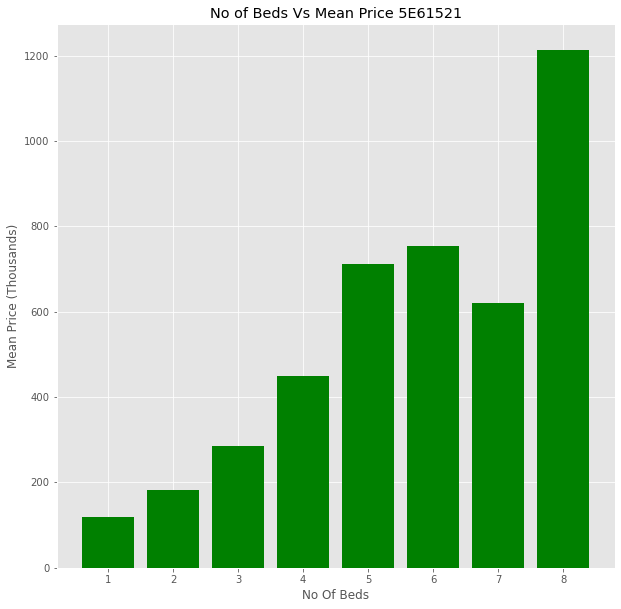

<Figure size 720x720 with 0 Axes>

In [49]:
performCalculations(cornwall, 8)